# Machine Learning in Python - Group Project 1

**Due Friday, March 10th by 16.00 pm.**

*include contributors names here (such as Name1, Name2, ...)*

## General Setup

In [1]:
# From the instructions, we can see that the data is taken from this library (but then modified) so we install this
# package and use the data for feature engineering!
#!pip install schrutepy
#!pip install nltk
#bla

In [2]:
# Add any additional libraries or submodules below

# Data libraries
import numpy as np
import pandas as pd
from schrutepy import schrutepy
import itertools

# Sentiment Analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# download the vader lexicon 
#nltk.download('vader_lexicon')

"""Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for
Sentiment Analysis of Social Media Text. Eighth International Conference on
Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014."""

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules that are necessary
from sklearn.preprocessing import PowerTransformer

In [3]:
# First we load the data 
data = pd.read_csv("the_office.csv")
# and our external data from SchrutePy. (Referenced at end)
data_from_schrutepy = schrutepy.load_schrute()

After making sure that all the necessary libraries or submodules are uploaded here, please follow the given skeleton to create your project report. 
- Your completed assignment must follow this structure 
- You should not add or remove any of these sections, if you feel it is necessary you may add extra subsections within each (such as *2.1. Encoding*). 

**Do not forget to remove the instructions for each section in the final document.**

## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client).* 

- If you use any additional data sources, you should introduce them here and discuss why they were included.

- Briefly outline the approaches being used and the conclusions that you are able to draw.

In [4]:
"""FINISH"""

'FINISH'

## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling.* 

- Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. 
- Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data.*

- Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. 
- Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

**All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.**

### 2.1 Exploratory Data Analysis

First we will explore the given dataset and show what the SchrutePy dataset looks like, which we downloaded from the package SchrutePy (reference below). This was hinted at in the instructions and will give us extra data to make our model.

Below is the given dataset from the_office.csv

In [5]:
data.head(2)

,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,main_chars
0,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,3706,2005-03-24,229,27,2757,15,Angela;Dwight;Jim;Kevin;Michael;Oscar;Pam;Phyl...
1,1,2,Diversity Day,Ken Kwapis,B.J. Novak,8.3,3566,2005-03-29,203,20,2808,12,Angela;Dwight;Jim;Kelly;Kevin;Michael;Oscar;Pa...


And here is the external dataset we use from SchrutePy:

In [6]:
data_from_schrutepy.head(2)

,index,season,episode,episode_name,director,writer,character,text,text_w_direction
0,1,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,Michael,All right Jim. Your quarterlies look very good...,All right Jim. Your quarterlies look very good...
1,2,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,Jim,"Oh, I told you. I couldn't close it. So...","Oh, I told you. I couldn't close it. So..."


This gives us a quick overview of what our columns are, how the data is inputted and how the overall structure of the data is. This is important for us so we can create efficient code later!
Now lets quickly describe our data:

In [7]:
display(data.describe().T.round(2))

,count,mean,std,min,25%,50%,75%,max
season,186.0,5.46,2.40,1.0,3.00,6.0,7.75,9.0
episode,186.0,12.48,7.23,1.0,6.00,12.0,18.00,28.0
imdb_rating,186.0,8.25,0.54,6.7,7.90,8.2,8.60,9.7
total_votes,186.0,2129.54,790.79,1393.0,1628.50,1954.0,2385.00,7934.0
n_lines,186.0,296.40,82.00,131.0,255.25,281.0,314.50,625.0
n_directions,186.0,50.15,23.94,11.0,34.00,46.0,60.00,166.0
n_words,186.0,3053.51,799.27,1098.0,2670.25,2872.5,3141.00,6076.0
n_speak_char,186.0,20.69,5.09,12.0,17.00,20.0,23.00,54.0


We can see we have 186 episodes in total, average rating of 8.25 (good show), several other parameters which will be important later when we feature engineer. We can see for example there is quite a large standard deviation in the amount of votes, which could skew our ratings. We also see our rating (target variable) has a standard deviation of 0.54, whereas the mean is 8.25. This shows there is enough spread of rating to make non-uniform predictions.

Are there any missing values?

In [8]:
print('The DataFrame: data, has ',data.isna().sum().sum(),' NaN values')

The DataFrame: data, has  0  NaN values


What about our external dataset?

In [9]:
data_from_schrutepy.isna().sum()

index                 0
season                0
episode               0
episode_name          0
director              0
writer                0
character             0
text                374
text_w_direction      5
dtype: int64

We can see we have the columns text and text_w_directions have NaN values. However, we will not be using these anyways since its just the script! So we do not have to worry about it :)

In [10]:
# We will no get our numerical data so we can visualize it:
num_data = data.copy()
num_data = num_data.drop(columns = ['episode_name', 'director', 'writer', 'air_date', 'main_chars'])

Now lets take a look at the distribution of the columns. (except of course the season number, episode, and air date)

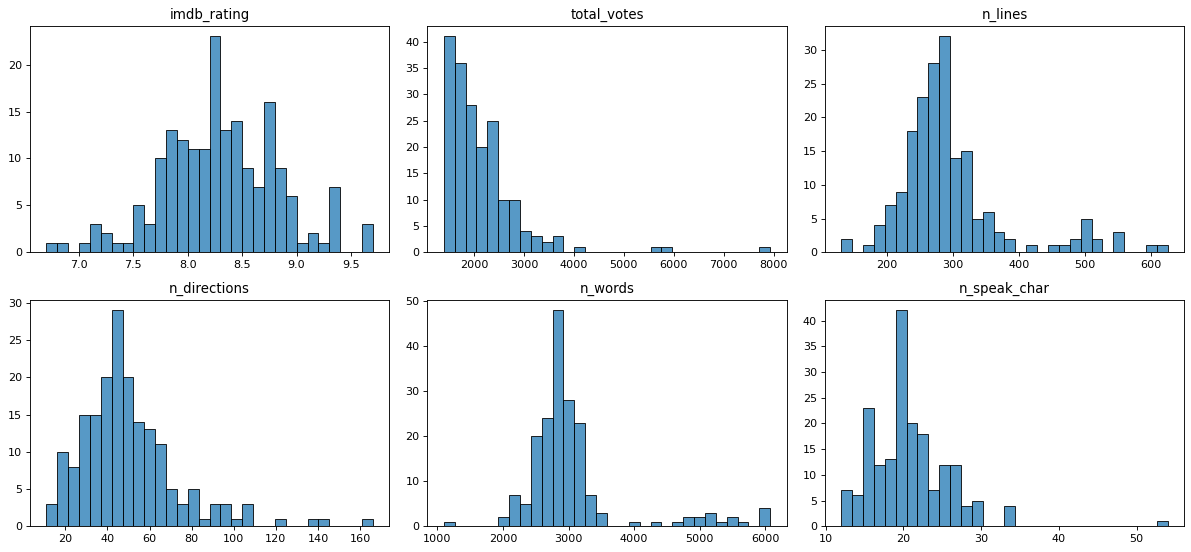

In [11]:
fig, axes = plt.subplots(figsize=(15,7), ncols=3, nrows=2)
axes = axes.flatten()

#define our columns
lst = ['imdb_rating','total_votes', 'n_lines', 'n_directions','n_words', 'n_speak_char']

for i, ax in enumerate(axes):
    sns.histplot(data = num_data[lst[i]], bins=30, ax=ax)
    ax.set_title(num_data[lst[i]].name)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.tight_layout()
plt.show()

Seeing the distribution is important because it lets us see several hints such as the Skewness, Gaussian-ness, etc. We can see the IMDB rating follows what seems like a normal distribution, whereas total votes decreasing seemingly exponentially. While the mathematical relation isn't necessarily important for each of the variables, it is important to understand total votes is skewed.

The graphs above allow us to visualise the distributions of all of our numerical features. We can see that some features are skewed and others follow a normal gaussian distribution. From this information, we will implement a box cox transformation to transform all non-gaussian features to gaussian. This will be done in the feature engineering section. Doing so will improve the predictions made by our linear regression model further down the line. 


Now before we move on to visualizing the correlation between variables, we want to see a breakdown of the relationship between writers and directors. After group discussion, we already know we want to include writers and directors in our model, but we need to make encoding of these variables. 

What is important to us is not the directors which had one hit wonders: the directors which had directed one episode and got lucky with a good rating. Maybe they are really good, but we are looking for consistency. The director for our final episode has to be consistently good.

<b> We set a threshold to choose which directors to encode in our model:</b> we want directors to have directed at least ***5 shows*** and then from there select the ***best 5***  

In [12]:
#get director dataframe which has their ratings and get a new column calculating the amount of times they directed
director = data[['director', 'imdb_rating']].reindex(columns=list(['director', 'imdb_rating', 'freq']), fill_value=1)
#calculates the sum
director = director.groupby('director')[['director', 'imdb_rating', 'freq']].sum() 
director['mean_rating'] = round(director['imdb_rating'] / director['freq'], 2)
# and sort the values for us on frequency (explained below) with a mean rating in the 75% percentile. 
director[director['freq']>=5].drop(columns = 'imdb_rating').sort_values(by='mean_rating', ascending=False).head(6)

/var/folders/y5/hx36dcps0wj9r1hxwq1x3zj80000gn/T/ipykernel_90529/2634553987.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  director = director.groupby('director')[['director', 'imdb_rating', 'freq']].sum()


,freq,mean_rating
director,,
Paul Feig,14,8.69
Ken Kwapis,12,8.54
Greg Daniels,14,8.52
Ken Whittingham,8,8.36
Charles McDougall,6,8.30
Jeffrey Blitz,11,8.30


We find that using this criteria, we get some of the consistnently best directors. Fortunately for us, we can see that all our directors with high frequency also have fairly good ratings, with Paul Feig having a very high rating consistently! We see that Jeffery Blitz has the same rating as Charles McDougall so we use Jeffery since he has a higher frequency!

Now lets do the same with writer. Here some times the writers collab. We will NOT split up the writers individually because we believe collaborations between writers can lead to better results than the writers individually together!

In [13]:
#get director dataframe which has their ratings and get a new column calculating the amount of times they directed
writer = data[['writer', 'imdb_rating']].reindex(columns=list(['writer', 'imdb_rating', 'freq']), fill_value=1)
#calculates the sum
writer = writer.groupby('writer')[['writer', 'imdb_rating', 'freq']].sum() 
writer['mean_rating'] = round(writer['imdb_rating'] / writer['freq'], 2)
# and sort the values for us on frequency (explained below) with a mean rating in the 75% percentile. 
writer[writer['freq']>=5].drop(columns = 'imdb_rating').sort_values(by='mean_rating', ascending=False).head(6)

/var/folders/y5/hx36dcps0wj9r1hxwq1x3zj80000gn/T/ipykernel_90529/4186175787.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  writer = writer.groupby('writer')[['writer', 'imdb_rating', 'freq']].sum()


,freq,mean_rating
writer,,
Greg Daniels,9,8.74
Gene Stupnitsky;Lee Eisenberg,7,8.51
Michael Schur,7,8.49
Paul Lieberstein,13,8.40
B.J. Novak,15,8.37
Lee Eisenberg;Gene Stupnitsky,6,8.35


Using the same reasoning, we can find the best consistently best 5 writers which we will choose to encode!

Now that we have done all of this: It is time to see the correlation between our variables so we can choose the best selection for our model to reduce feature dependence!

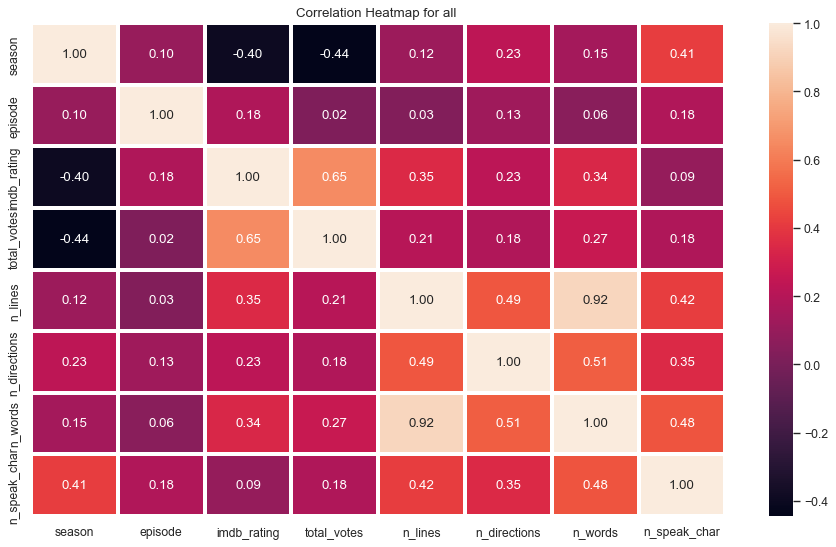

In [14]:
#heatmap
sns.set(rc={'figure.figsize': (14, 8)})
sns.heatmap(num_data.corr(), annot = True, fmt = '.2f', linewidths = 2)
plt.title("Correlation Heatmap for all ")
plt.show()

We can see some very important things to reduce colinearity/codependence:

* n_lines and n_words is very highly correlated (obviously) so we will deal with that later. Other n_* lines are also slightly correlated so we will find a way to deal with those too.
* imbd_rating and total_votes is also very highly correlated. 
    + We need to be careful here because this implies episodes with a large number of votes often is rated more highly. We cannot have number of votes as an input variable in our model because for a reunion episode, we obviosuly cannot say a priori the amount of votes we will get. To deal with this we will look deeper into the problem: We can adjust the imdb rating based on the amount of votes it got or choose to ignore the correlation if we find the relationship to be insignificant. More on this later...
* The same is with rating and season number. However, since we cannot account for the season number in our reunion episode, we cannot do anything about this either. We could weight each season to imbd rating but do not believe this to be outside the scope of this project. It would be great for further research!

Firstly, lets look at how we can deal with number of ____ feautures

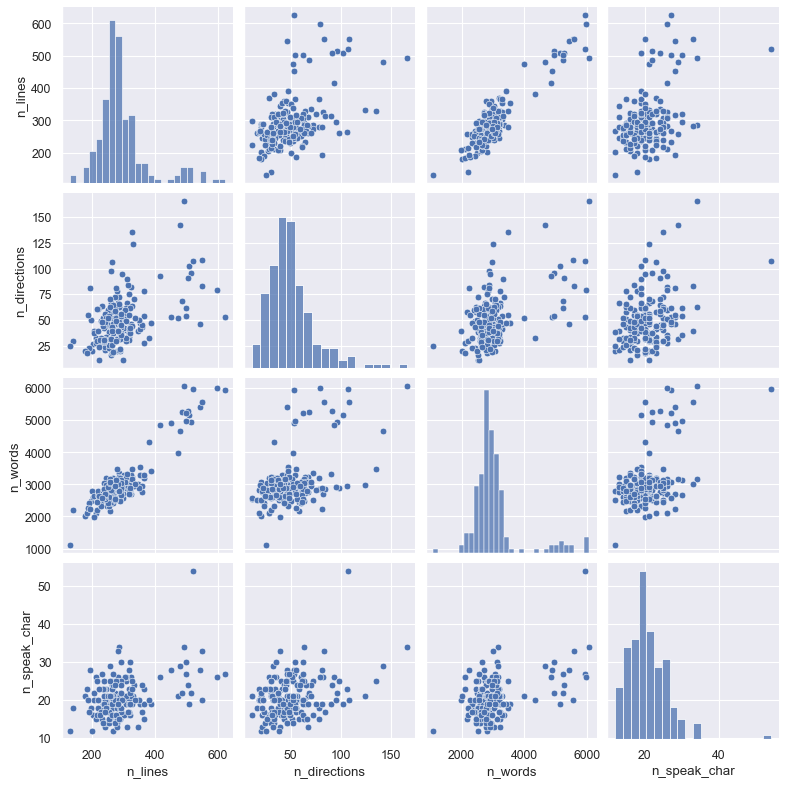

In [15]:
# we now want to see how the highly correlated values are relates:
sns.pairplot(data[['n_lines','n_directions','n_words', 'n_speak_char']])

We can see a very clear __linear__ relationship between n_lines and n_words which is good for us since it means we can combine or eliminate one of those feautres. The other variables we do not see as strong relationship so we are hesitant to eliminate those. We will see if testing the model on a reduced parameter space will improve performance later, in which we can reduce some of these feautures.

### 2.2 Feature Engineering

<span style="color:red">***FIX/Adjust BELOW***</span>


#### Features we are eliminating (from the_office.csv) and why:
* We will eliminate the column n_words since we found that n_lines and n_words were highly linearly correlated. Doing so will reduce collinearity in our final model. 
* We will remove season number, episode number and air_date because in our opinion, this should not have an affect on the reunion episode. We consider our personal experience and realize most of the office nowadays is watched through streaming services, which are independent of air date. We do however acknowledge that the rating could be dependent on air_time and season numbers, although marginally

#### Features we will engineer:
* We want to see how many times do the main characters talk during the episode and see if it effects the rating.
* We want to OneHotEncode the writers and directors
* OneHotEncode

#### Will we adjust the IMDB rating according to the number of votes and season number to evenly weight the ratings for our model?
As a group, we have decided to _______

#### Finally, we will standardise all of our final numerical features
This includes standardising the following: 

#### 2.2.1 How many times do characters speak?

We can get this data from our external source: data_from_schrutepy

In [16]:
# make a data which is how many times does {Character} speak in each episode?
speak_count = pd.DataFrame(data_from_schrutepy.groupby(by=['season','episode','character']).count()['text']).unstack()
speak_count.head(1)

text                                          \
character      "Angela" "Jim" "Jo" "Phyllis" (Pam's mom) Heleen   
season episode                                                    
1      1            NaN   NaN  NaN       NaN                NaN   

                                                                   \
character      3rd Athlead Employee 4th Athlead Employee A.J.  AJ   
season episode                                                      
1      1                        NaN                  NaN  NaN NaN   

                              ...                                          \
character      Aaron Rodgers  ... Worker Wrangler Young Man Young Michael   
season episode                ...                                           
1      1                 NaN  ...    NaN      NaN       NaN           NaN   

                                                     
character      Younger Guy Zeke Zion abe sAndy song  
season episode                                       
1      1               NaN  NaN  NaN NaN   NaN  NaN  

[1 rows x 773 columns]

We can see that we now have 773 characters in the office, most of which do not speak: a lot of minor characters we do not wish to include in our model. So now lets filter the main characters only: this can be found in the the_office.csv file.

In [17]:
#correlate this to the main characters in this episode (from the_office.csv) and delete all minor characters
a = data.main_chars.str.split(';')
#this gets all the unique main characters from the_office.csv and save it as main_characters
main_characters = list(itertools.chain.from_iterable(a))
main_characters = pd.DataFrame(main_characters).drop_duplicates().reset_index()[0]

# adjust the dataFrame index
speak_count = speak_count.reset_index(names = ['episode','season', 'character'], col_level=1)
# get just the main character
speak_count_main_characters = speak_count['text'][main_characters].fillna(0)
speak_count_main_characters.head()
#then add the main characters to the model input data!
data[speak_count_main_characters.columns] = speak_count_main_characters
data.head(2)

,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,...,Phyllis,Ryan,Stanley,Kelly,Toby,Meredith,Darryl,Creed,Andy,Erin
0,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,3706,2005-03-24,229,27,...,2.0,8.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2,Diversity Day,Ken Kwapis,B.J. Novak,8.3,3566,2005-03-29,203,20,...,0.0,4.0,5.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0


As we can see, this worked out really well! We now have extra columns which shows how often the main characters speak in the show per episode!

Below we can show a visual representation of how many times each main character speaks!

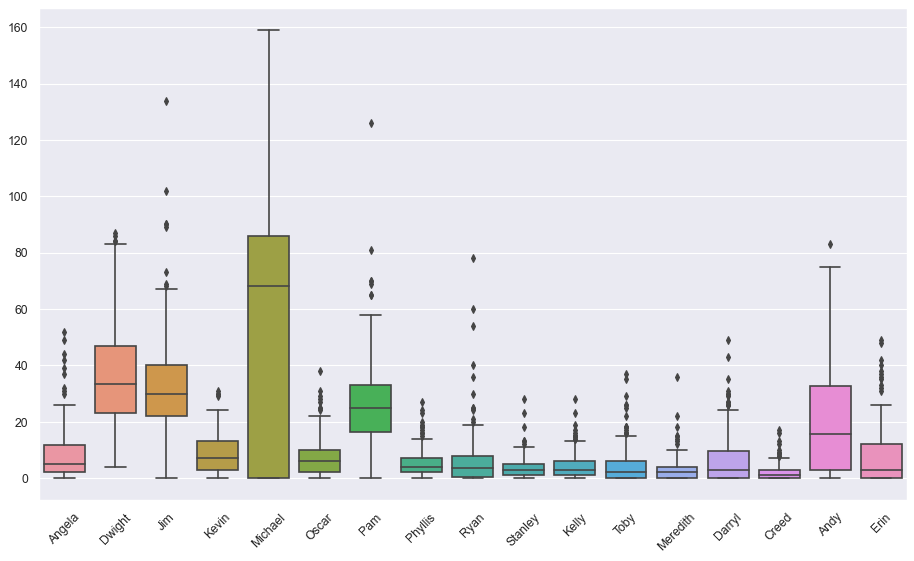

In [18]:
sns.boxplot(data[main_characters])
plt.xticks(rotation=45) # rotate x-labels 45 degrees
plt.show()

We can see there are a lot of outliers. This shows some episodes focus on specific characters

    ***REMOVE EPISODES WITH A FOCUS ON ONE CHARACTER*** AS further expansion on project

#### 2.2.2 One Hot Encode the writers and directors:

It is now time to one hot encode the important writers and directors we found in the EDA section.

In [19]:
# First we define the directors and writers we are looking 
directors = ['Paul Feig','Ken Kwapis','Greg Daniels','Ken Whittingham','Jeffrey Blitz']
writers = ['Greg Daniels','Gene Stupnitsky;Lee Eisenberg','Michael Schur','Paul Lieberstein','B.J. Novak']

# perform encoding on the director column
encoded = pd.get_dummies(data['director'].apply(lambda x: x if x in directors else 'Other_director'))

# merge the encoded dataframe with the original dataframe
data = pd.concat([data, encoded], axis=1)

# drop the original director column
data.drop('director', axis=1, inplace=True)

data.head(1)

,season,episode,episode_name,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,...,Darryl,Creed,Andy,Erin,Greg Daniels,Jeffrey Blitz,Ken Kwapis,Ken Whittingham,Other_director,Paul Feig
0,1,1,Pilot,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,3706,2005-03-24,229,27,2757,...,0.0,0.0,0.0,0.0,0,0,1,0,0,0


In [20]:
#now lets do the same but with the writers!
# perform encoding on the director column
encoded = pd.get_dummies(data['writer'].apply(lambda x: x if x in writers else 'Other_writer'))

# merge the encoded dataframe with the original dataframe
data = pd.concat([data, encoded], axis=1)

# drop the original director column
data.drop('writer', axis=1, inplace=True)

data.head(1)

,season,episode,episode_name,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,...,Ken Kwapis,Ken Whittingham,Other_director,Paul Feig,B.J. Novak,Gene Stupnitsky;Lee Eisenberg,Greg Daniels,Michael Schur,Other_writer,Paul Lieberstein
0,1,1,Pilot,7.6,3706,2005-03-24,229,27,2757,15,...,1,0,0,0,0,0,0,0,1,0


#### 2.2.3 Dropping our Unessecary Columns

Its now time to get rid of season, episode,episode_name,total_votes	and air_date so we can start to deal with the numbers of words and votes

In [21]:
data = data.drop(columns=['season', 'episode', 
                          'episode_name','total_votes',
                         'air_date', 'main_chars'])

#### 2.2.4 What to do with n_lines and n_words

We know from our correlation matrix that these two are highly linearly correlated. That is why we will drop the n_words column (we could also have dropped n_lines instead). 

We will also know create a copy of our dataFrame to start working on the model with

In [22]:
data = data.drop(columns=['n_words'])

In [23]:
data.iloc[:,4:21] = data.iloc[:,4:21].div(data.iloc[:,1], axis=0)
data.drop("n_lines", axis = 1)

,imdb_rating,n_directions,n_speak_char,Angela,Dwight,Jim,Kevin,Michael,Oscar,Pam,...,Ken Kwapis,Ken Whittingham,Other_director,Paul Feig,B.J. Novak,Gene Stupnitsky;Lee Eisenberg,Greg Daniels,Michael Schur,Other_writer,Paul Lieberstein
0,7.6,27,15,0.004367,0.126638,0.157205,0.004367,0.353712,0.013100,0.174672,...,1,0,0,0,0,0,0,0,1,0
1,8.3,20,12,0.019704,0.083744,0.118227,0.039409,0.369458,0.064039,0.059113,...,1,0,0,0,1,0,0,0,0,0
2,7.9,21,13,0.020492,0.254098,0.172131,0.024590,0.229508,0.036885,0.131148,...,0,1,0,0,0,0,0,0,0,1
3,8.1,24,14,0.028807,0.193416,0.201646,0.012346,0.279835,0.057613,0.090535,...,0,0,1,0,0,0,0,1,0,0
4,8.4,49,18,0.013043,0.108696,0.091304,0.004348,0.452174,0.008696,0.060870,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,8.0,59,24,0.007326,0.212454,0.054945,0.018315,0.000000,0.025641,0.032967,...,0,0,1,0,0,0,0,0,1,0
182,8.0,48,27,0.068376,0.089744,0.072650,0.042735,0.000000,0.008547,0.094017,...,0,0,1,0,0,0,0,0,1,0
183,8.9,33,20,0.078534,0.141361,0.164921,0.034031,0.000000,0.049738,0.078534,...,0,0,0,0,0,0,0,0,1,0
184,9.3,54,30,0.077844,0.173653,0.177645,0.059880,0.000000,0.055888,0.067864,...,0,0,1,0,0,0,0,0,1,0


#### 2.2.5 Sentiment Score

We now will run the sentiment analysis on the script per episode. This uses the Vader dictionary to determine how happy/neutral/sad a given script is!

In [24]:
# instantiate the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# define some text to analyze (fill the silences (nan) with  ' ')
text = data_from_schrutepy.fillna(' ').groupby(['season', 'episode'])['text'].apply(' '.join)

# analyze the sentiment of the text
scores = [analyzer.polarity_scores(i) for i in text]

In [25]:
# get the neutral, positive and negative sentiment scores
data['pos_score'] = [scores[i]['pos'] for i in range(len(scores))]
data['neg_score'] = [scores[i]['neg'] for i in range(len(scores))]

### 2.3 Feature Transformation

The final step is to transform our data (using yeo-johnson) to improve our data normality and symmetry! 

In [26]:
yeo = PowerTransformer()
data_scaled = yeo.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

In [27]:
# df will be the dataframe we are working with now
df = data.copy()
df_scaled = data_scaled.copy()

df.to_csv('final_office.csv')
df_scaled.to_csv('final_office_scaled.csv')

## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model.*

- You are strongly encouraged to explore many different modeling methods (e.g. linear regression, regression trees, lasso, etc.) but you should not include a detailed narrative of all of these attempts. 
- At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.

*For example if you considered a linear regression model, a classification tree, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

**This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.**

In [28]:
#In GIT there is the final csv file called 
filneame = './final_office.csv'
# in case you guys do not want to run the entire sections above

# to inverse the scaling we used: after prediction do: 
# yeo.inverse_transform(prediction_data)
# and be careful! of the column names!

In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import cross_validate
!pip install  imbalanced-learn
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import ColumnTransformer
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
import sklearn
from sklearn.metrics import mean_squared_error, r2_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 1.9 MB/s eta 0:00:00a 0:00:01


In [31]:
kf = KFold(n_splits = 5, shuffle = True, random_state=42)

In [32]:
def tidy_scores(score_dict):
    df = pd.DataFrame(score_dict)
    df.loc['mean'] = df.mean()
    df.loc['sd'] = df.std()
    df.rename({"test_score":"val_score"}, axis=1, inplace=True)
    df.index.name = "fold"
    return df.round(2)

In [33]:
def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Actual vs Fitted plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted vs Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model (MSE, RMSE, Rsqr) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return MSE, RMSE, Rsqr

In [34]:
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

In [35]:
df = pd.read_csv("final_office_scaled.csv")

In [36]:
Xs = df.drop(['Unnamed: 0', 'imdb_rating', 'Other_director', 'Other_writer'], axis = 1)
ys = df['imdb_rating']
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size = 0.2, random_state = 42)

In [37]:
# find Ridge's optimal alpha
alphas = np.linspace(0, 60, num=200)
gs = GridSearchCV(
    make_pipeline(
    linear_model.Ridge()),
    param_grid = {'ridge__alpha': alphas},
    cv = KFold(5, shuffle = True, random_state = 42),
    scoring = "neg_root_mean_squared_error"
)

gs.fit(Xs_train, ys_train)
print(gs.best_params_)

{'ridge__alpha': 60.0}


In [38]:
best_ridge = 60.0

In [39]:
# find lasso's optimal alpha
alphas = np.logspace(-3, 1, num=200)
gs = GridSearchCV(
    make_pipeline(
    linear_model.Lasso()),
    param_grid = {'lasso__alpha': alphas},
    cv = KFold(5, shuffle = True, random_state = 42),
    scoring = "neg_root_mean_squared_error"
)

gs.fit(Xs_train, ys_train)
print(gs.best_params_)

{'lasso__alpha': 0.10234114021054527}


In [40]:
best_lasso = 0.10234114021054527

In [41]:
# model with optimal alpha
# Description of different models via pipeline

linear_pipe = LinearRegression()
knn_pipe = KNeighborsRegressor(n_neighbors=3)
lasso_pipe = linear_model.Lasso(alpha = best_lasso)
ridge_pipe = linear_model.Ridge(alpha = best_ridge)


# Collection of all models
model_dict = {
    'LinearRegression': linear_pipe,
    'KNN': knn_pipe,
    'Lasso': lasso_pipe,
    'Ridge': ridge_pipe}

In [42]:
# Implementing the 5-fold cross validation for each model in a loop
for i, model_name in enumerate(model_dict): 
    scores = cross_validate(model_dict[model_name], Xs_train, ys_train, cv = kf, return_train_score = True)
    scores_df = tidy_scores(scores)
    scores_df['model'] = model_name
    scores_df = scores_df.set_index("model", append=True)
    scores_df = scores_df.swaplevel()
    
    if i == 0:
        all_scores = scores_df
    else:
        all_scores = pd.concat([all_scores, scores_df], axis=0)

In [43]:
# score of optimal model
# Mean values for the train and valid scores        
display(all_scores.xs('mean', level=1, drop_level=False))
# Std Dev. values for the train and valid scores
display(all_scores.xs('sd', level=1, drop_level=False))

,,fit_time,score_time,val_score,train_score
model,fold,,,,
LinearRegression,mean,0.0,0.00,-0.02,0.51
KNN,mean,0.0,0.01,0.10,0.53
Lasso,mean,0.0,0.00,0.25,0.39
Ridge,mean,0.0,0.00,0.18,0.45


,,fit_time,score_time,val_score,train_score
model,fold,,,,
LinearRegression,sd,0.0,0.00,0.38,0.03
KNN,sd,0.0,0.01,0.07,0.02
Lasso,sd,0.0,0.00,0.05,0.02
Ridge,sd,0.0,0.00,0.11,0.02


In [44]:
ms = linear_model.Lasso(alpha = best_lasso).fit(Xs_train, ys_train)
coef = get_coefs(ms)[1:]
feature = Xs_train.columns
pd.DataFrame(coef, feature)

,0
n_lines,0.252135
n_directions,0.074758
n_speak_char,0.011002
Angela,0.000000
Dwight,-0.000000
Jim,0.000000
Kevin,0.000000
Michael,0.234996
Oscar,-0.000000
Pam,-0.000000


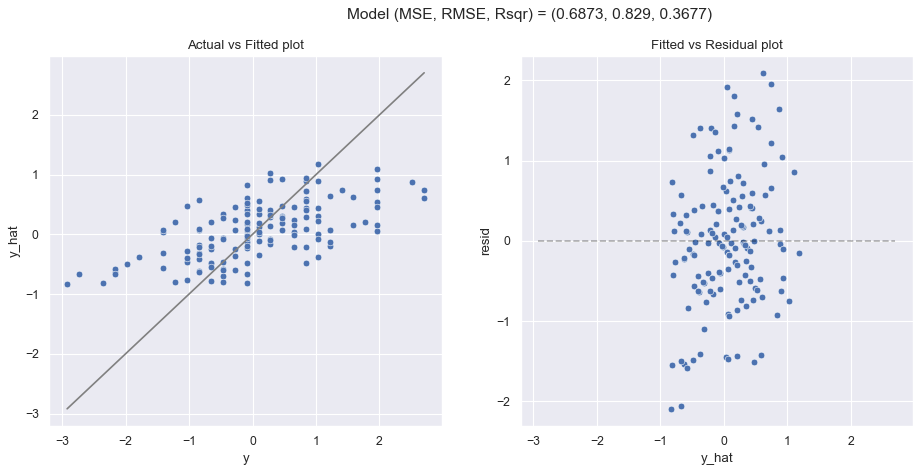

(0.6872803655710886, 0.8290237424652497, 0.36768463522648)

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
lasso_model = lasso_pipe.fit(Xs_train , ys_train)
model_fit(lasso_model, Xs_train, ys_train, plot = True)

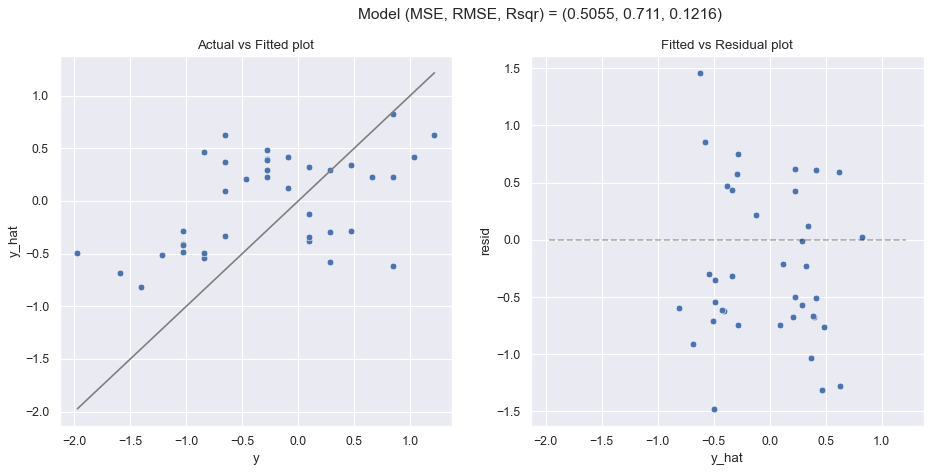

(0.505461259406931, 0.710957987089906, 0.12158266908543836)

In [46]:
model_fit(lasso_model, Xs_test, ys_test, plot = True)

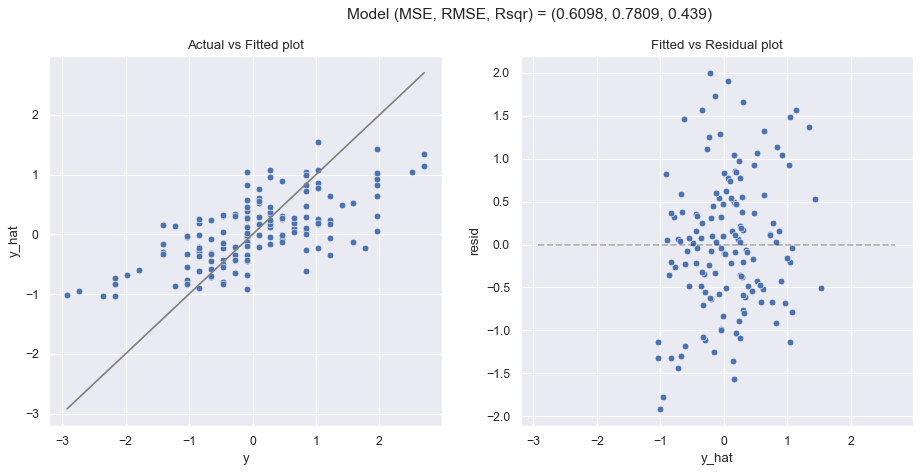

(0.609768657384698, 0.7808768516127866, 0.43899737234413405)

In [47]:
ridge_model = ridge_pipe.fit(Xs_train , ys_train)
model_fit(ridge_model, Xs_train, ys_train, plot = True)

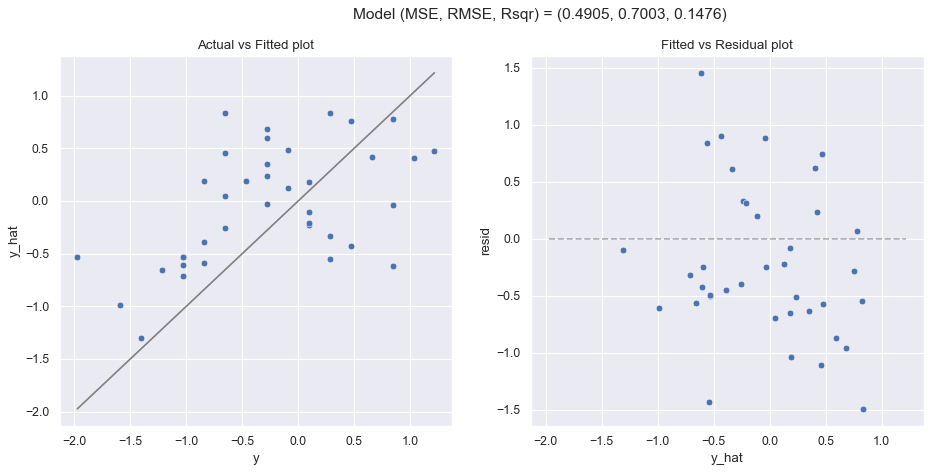

(0.49047361743156254, 0.7003382164579929, 0.14762898661361745)

In [48]:
model_fit(ridge_model, Xs_test, ys_test, plot = True)

## 4. Discussion and Conclusions


*In this section you should provide a general overview of **your final model**, its **performance**, and **reliability**.* 

- You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.

- This should be written with a target audience of a NBC Universal executive who is with the show and university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. 

- Your goal should be to convince this audience that your model is both accurate and useful.

- Finally, you should include concrete recommendations on what NBC Universal should do to make their reunion episode a popular as possible.

**Keep in mind that a negative result, i.e. a model that does not work well predictively, but that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explanations / justifications.**

In [49]:
# add that we might want to condiser the timing of the episodes when they aired and that it could be cool to get data to see h
# how much timing afffected the ratings

# add idea about adjusted-IMDB rating based on the amount of votes (takes in the correlation between votes and rating)



## 5. References

*In this section, you should present a list of external sources (except the course materials) that you used during the project, if any*

- Additional data sources can be cited here, in addition to related python documentations, any other webpage sources that you benefited from

In [ ]:
### INSERT reference to shrutepy here

#refernce for trnasformation
I.K. Yeo and R.A. Johnson, “A new family of power transformations to improve normality or symmetry.” Biometrika, 87(4), pp.954-959, (2000).